In [1]:
using Distributions, Plots, KernelDensity


# Bayesian Methods



A **data generating process** is a model characterized by a parameter
vector, and the data is generated from the model at a **fixed parameter** vector, $\theta_{0}$. 

Bayesians view **data as given**,
and **update beliefs about a parameter** using the information about the
parameter contained in the data. 

There's nothing obviously contradictory
in these views. Nevertheless, it's not hard to find discussions where
there are disagreements.

Here, I'm trying to address a model with a fixed non-random parameter
about which we would like to learn. As long as the object of interest
(the dgp and it's parameter) is agreed upon, then we can contemplate
using **any** convenient tool.

Frequentist
- $\theta$ is fixed, but unknown
- Uncertainty comes from the sampling uncertainty. That is, from the fact that we can get different samples.
- All probabilistic statements are statements about sampling uncertainty.

Bayesian 
- $\theta$ is random
- Data is treated as fixed after observed
- All probabilistic statements are about uncertainty about $\theta$

As long as one takes the view that there is a fixed unknown parameter
value $\theta_{0}$ which generates all samples, then frequentist
and Bayesian methods are trying to inform us about the same object,
and the choice between tools may become one of convenience. 

## Definitions

The Bayesian approach summarizes beliefs about parameters using a
density function:
- There is a true unknown parameter vector, $\theta_{0}$, and the density,
$\pi(\theta)$, which is known as the **prior**, reflects current
beliefs about the parameter, before observing the sample. It is assumed
that the econometrician can provide this density.
- We also have sample information, $y$=$\left\{ y_{1},y_{2},...y_{n}\right\} $.
We're already familiar with the likelihood function, $f(y|\theta)$,
which is the density of the sample given a parameter value. 

Given these two pieces, we can write the joint density of the sample
and the beliefs:
$$
f(y,\theta)=f(y|\theta)\pi(\theta)
$$
We can get the marginal likelihood by integrating
out the parameter, integrating over its support $\Theta$:
$$
f(y)=\int_{\Theta}f(y,\theta)d\theta
$$
The last step is to get the **posterior** of the parameter. This
is simply the density of the parameter conditional on the sample,
and we get it in the normal way we get a conditional density, using
[**Bayes' theorem**](https://www.youtube.com/watch?v=HZGCoVF3YvM):
$$
f(\theta|y)=\frac{f(y,\theta)}{f(y)}=\frac{f(y|\theta)\pi(\theta)}{f(y)}
$$

- The movement from the prior to the posterior reflects the **learning**
that occurs about the parameter when one receives the sample information.
- The sources of information used to make the posterior are the prior
and the likelihood function. 
- Once we have the posterior, one can provide a complete probabilistic
description about our updated beliefs about the parameter, using quantiles
or moments of the posterior. 


So far, this is pretty straightforward. The complications are mostly
computational. To illustrate, the posterior mean is
$$
E(\theta|y)=\int_{\Theta}\theta f(\theta|y)d\theta=\frac{\int_{\Theta}\theta f(y|\theta)\pi(\theta)d\theta}{\int_{\Theta}f(y,\theta)d\theta}
$$
 
- One can see that a means of integrating will be needed.
- Only in very special cases will the integrals have analytic solutions.
-  Otherwise, computational methods will be needed. Advances in computational
methods are what have lead to the increased use of Bayesian methods.


#### Extensions
[Chernozhukov and Hong (2003) "An MCMC Approach to Classical Estimation"](http://www.sciencedirect.com/science/article/pii/S0304407603001003) is a very interesting article
that shows how Bayesian methods may be used with criterion functions that are associated with
classical estimation techniques.

For example, when the criterion function $L_n(\theta)$ in their paper is set to the log-likelihoodfunction and the pseudo-prior $\pi(\theta)$ is a real Bayesian prior, the class of estimators discussed by CH reduces to the ordinary Bayesian posterior mean. this estimator is consistent and asymptotically normally distributed. In
particular, the Bayesian posterior mean has the same asymptotic distribution as does the ordinary
maximum likelihood estimator.
- the intuition is clear: as the amount of information coming from the
sample increases, the likelihood function brings an increasing amount
of information, relative to the prior. Eventually, the prior is no
longer important for determining the shape of the posterior.
- when the sample is large, the shape of the posterior depends on the
likelihood function. The likelihood function collapses around $\theta_{0}$
when the sample is generated at $\theta_{0}.$ The same is true of
the posterior, it narrows around $\theta_{0}$. This causes the posterior
mean to converge to the true parameter value. In fact, all quantiles
of the posterior converge to $\theta_{0}$. Chernozhukov and Hong
discuss estimators defined using quantiles.
- For an econometrician coming from the frequentist perspective, this
is attractive. The Bayesian estimator has the same asymptotic behavior
as the MLE. There may be computational advantages to using the Bayesian
approach, because there is no need for optimization. If the objective
function that defines the classical estimator is irregular (multiple
local optima, nondifferentiabilities, noncontinuities...), then optimization
may be very difficult. However, Bayesian methods that use integration
may be more tractable. This is the main motivation of CH's paper.
Additional advantages include the benefits if an informative prior
is available. When this is the case, the Bayesian estimator can have
better small sample performance than the maximum likelihood estimator.

## Example (Exponential Distribution)

Suppose data is generated by i.i.d. sampling from an exponential distribution
with mean $\theta$. An exponential random variable takes values on
the positive real numbers. Waiting times are often modeled using the
exponential distribution.

- The density of a typical sample element is $f(y|\theta)=\frac{1}{\theta}e^{-y/\theta}$.
The likelihood is simply the product of the sample contributions.
- Suppose the prior for $\theta$ is $\theta\sim$lognormal(1,1). This
means that the logarithm of $\theta$ is standard normal. We use a
lognormal prior because it enforces the requirement that the parameter
of the exponential density be positive.

In [2]:
# the prior is lognormal(1,1)
function prior(theta)
    d = LogNormal(1.0,1.0)
    p = pdf.(Ref(d), theta)
    pmean = exp(1.5) # mean of lognormal is exp(mu+sig/2)
    return p, pmean
end

# the likelihood function
function likelihood(y, theta)
    dens = zeros(size(theta))
    for i = 1:size(theta,1)
        d = Exponential(theta[i])
        dens[i] = prod(pdf.(Ref(d), y))
    end
    return dens
end


# joint is prior X likelihood
function joint(y, theta)
    l = likelihood(y, theta)
    p, junk = prior(theta)
    dens = l.*p
end

# compute marginal likelihood of Y by integrating out theta (crude, only illustrative)
function marginal(y)
    dens = 0.0
    theta = 0.0
    delta = 0.01
    # evaluate joint over grid
    for r = 1:1000
        theta += delta
        dens += joint(y, theta)
    end
    # marginalize by integrating the joint (sum up height X width)
    dens = dens*delta
end

# the posterior, by Bayes' Law
function posterior(y, theta)
    m = marginal(y)
    j = joint(y, theta)
    dens = j ./ m
    thetas = range(0.01,stop=10,length=1000)
    pmean = sum(dens.*thetas.*0.01)
    return dens, pmean
end
;

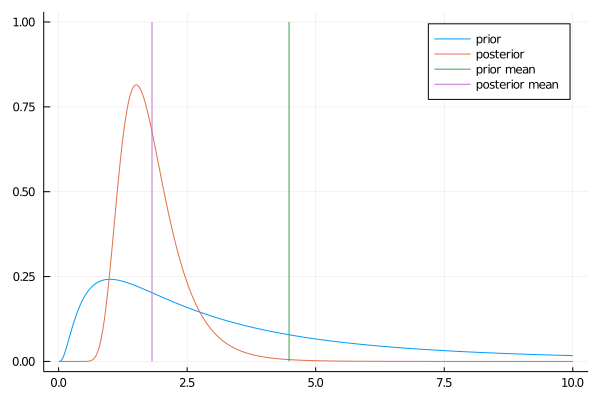

In [4]:
n = 10  # sample size
theta = 3 # true theta
y = rand(Exponential(theta), n) # sample from exponential(theta)
# make plots
thetas = range(0.01,stop=10,length=1000)
p, priormean = prior(thetas)
post, postmean = posterior(y, thetas)
plot(thetas, [p post], label = ["prior" "posterior"])
plot!([priormean, priormean], [0.0, 1.0], label = "prior mean")
plot!([postmean, postmean], [0.0, 1.0], label = "posterior mean")

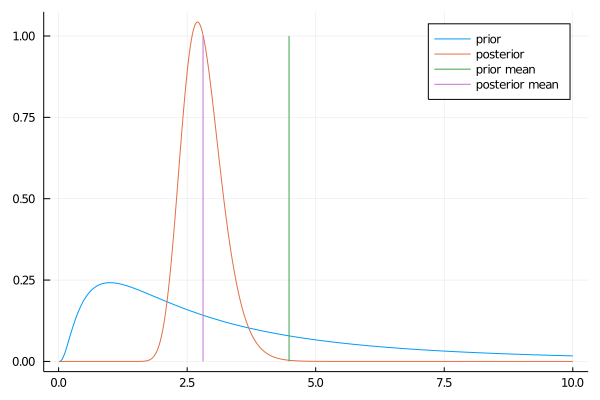

In [3]:
n = 50  # sample size
theta = 3 # true theta
y = rand(Exponential(theta), n) # sample from exponential(theta)
# make plots
thetas = range(0.01,stop=10,length=1000)
p, priormean = prior(thetas)
post, postmean = posterior(y, thetas)
plot(thetas, [p post], label = ["prior" "posterior"])
plot!([priormean, priormean], [0.0, 1.0], label = "prior mean")
plot!([postmean, postmean], [0.0, 1.0], label = "posterior mean")

Note how the
posterior is more concentrated around the true parameter value when sample has size 50. Also note how the posterior mean is closer to the prior
mean when the sample is small. When the sample is small, the likelihood
function has less weight, and more of the information comes from the
prior. When the sample is larger, the likelihood function will have
more weight, and its effect will dominate the prior's.

## Markov Chain Monte Carlo (MCMC)

To compute the posterior mean, we need to evaluate
\begin{align*}
E(\theta|y) & =\int_{\Theta}\theta f(\theta|y)d\theta\\
= & \frac{\int_{\Theta}\theta f(y|\theta)\pi(\theta)d\theta}{\int_{\Theta}f(y,\theta)d\theta}.
\end{align*}
- Note that both of the integrals are multiple integrals, with the dimension
given by that of the parameter, $\theta.$
- Under some special circumstances, the integrals may have analytic
solutions: e.g., Gaussian likelihood with a Gaussian prior leads to
a Gaussian posterior. 
- When the dimension of the parameter is low, quadrature methods may
be used. What we have done with marginal(y) and posterior(y, theta) 
is an unsophisticated example of this. More sophisticated methods
use an intelligently chosen grid to reduce the number of function
evaluations. Still, these methods only work for dimensions up to 3
or so.
- Otherwise, some form of simulation-based ''Monte Carlo'' integration
must be used. The basic idea is that $E(\theta|y)$ can be approximated
by $(1/S)\sum_{s=1}^{S}\theta^{s}$, where $\theta^{s}$ is a random
draw from the posterior distribution $f(\theta|y)$. 


**How to make draws from the posterior** when in general we can't compute
the posterior?
- the law of large numbers tells us that this average will converge
to the desired expectation as $S$ gets large
- convergence will be more rapid if the random draws are independent
of one another, but insisting on independence may have computational
drawbacks.


Monte Carlo methods include importance sampling, Markov chain Monte
Carlo (MCMC) and sequential Monte Carlo (SMC, also known as particle
filtering). The great expansion of these methods over the years has
caused Bayesian econometrics to become much more widely used than
it was in the not so distant (for some of us) past. There is much
literature - here we will only look at a basic example that captures
the main ideas.



### Metropolis-Hastings

Let's consider the basic **Metropolis-Hastings MCMC** algorithm. We will
generate a long realization of a Markov chain process for $\theta$,
as follows:

The prior density is $\pi(\theta)$, as above.

Let $g(\theta^{*};\theta^{s})$ be a proposal density, which describes
the density of a trial value $\theta^{*}$ conditional on starting
at $\theta^{s}$. It must be possible to sample from the proposal.
This gives a new trial parameter value $\theta^{*}$, given the most
recently accepted parameter value $\theta^{s}$. A proposal will be
accepted if
$$
\frac{f(\theta^{*}|y)}{f(\theta^{s}|y)}\frac{g(\theta^{s};\theta^{*})}{g(\theta^{*};\theta^{s})}>\alpha
$$
where $\alpha$ is a $U(0,1)$ random variate. 

There are two parts to the numerator and denominator: the posterior,
and the proposal density. 
- The numerator, when the trial value of the proposal has
a higher posterior, acceptance is favored. 
- The density associated with returning to $\theta^{s}$
when starting at $\theta^{*}$, which has to do with the reversibility
of the Markov chain. If this is too low, acceptance is not favored.
We don't want to jump to a new region if we will never get back, as
we need to sample from the entire support of the posterior. 

The two together mean that we will jump to a new area only if we are
able to eventually jump back with a reasonably high probability. The
probability of jumping is higher when the new area has a higher posterior
density, but lower if it's hard to get back. 

The idea is to sample from all regions of the posterior, those with
high and low density, sampling more heavily from regions of high density.
We want to go occasionally to regions of low density, but it is important
not to get stuck there.

Note that the ratio of posteriors is equal to the ratio of likelihoods
times the ratio of priors:
$$
\frac{f(\theta^{*}|y)}{f(\theta^{s}|y)}=\frac{f(y|\theta^{*})}{f(y|\theta^{s})}\frac{\pi(\theta^{*})}{\pi(\theta^{s})}
$$
because the marginal likelihood $f(y)$ is the same in both cases.
We don't need to compute that integral! We don't need to know the
posterior, either. The acceptance criterion can be written as: accept
if
$$
\frac{f(y|\theta^{*})}{f(y|\theta^{s})}\frac{\pi(\theta^{*})}{\pi(\theta^{s})}\frac{g(\theta^{s};\theta^{*})}{g(\theta^{*};\theta^{s})}>\alpha
$$
otherwise, reject


From this, we see that the information needed to determine if a proposal
is accepted or rejected is the prior, the proposal density, and the
likelihood function $f(y|\theta)$.
- in principle, the prior is non-negotiable. In practice, people often
chose priors with convenience in mind
- the likelihood function is what it is
- the place where artistry comes to bear is the choice of the proposal
density
- when the proposal density is symmetric, so that $g(\theta^{s};\theta^{*})=g(\theta^{*};\theta^{s})$,
the acceptance criterion simplifies to 
$$
\frac{f(y|\theta^{*})}{f(y|\theta^{s})}\frac{\pi(\theta^{*})}{\pi(\theta^{s})}>\alpha
$$
A random walk proposal, where the trial value is the current value
plus a shock that doesn't depend on the current value, satisfies symmetry.


The steps are:
1.  the algorithm is initialized at some $\theta^{1}$
2.  for $s=2,...,S,$ 
    1. draw $\theta^{*}$ from $g(\theta^{*};\theta^{s})$
    2. according to the acceptance/rejection criterion, if the result is acceptance, set $\theta^{s+1}=\theta^{*}$, otherwise set $\theta^{s+1}=\theta^{s}$
    3. iterate



Once the chain is considered to have stabilized, say at iteration
$r$, the values of $\theta^{s}$ for $s>r$ are taken to be draws
from the posterior. The posterior mean is computed as the simple average
of the value. Quantiles, etc., can be computed in the appropriate
fashion.

The art of applying these methods consists of providing a good proposal
density so that the acceptance rate is reasonably high, but not too
high. There is a vast literature on this, and the vastness of the
literature should serve as a warning that getting this to work in
practice is not necessarily a simple matter. If it were, there would
be fewer papers on the topic.

- too high acceptance rate: this is usually due to a proposal density
that gives proposals very close to the current value, e.g, a random
walk with very low variance. This means that the posterior is being
explored inefficiently, we travel around through the support at a
very low rate, which means the chain will have to run for a (very,
very...) long time to do a thorough exploration.
- too low acceptance rate: this means that the steps are too large,
and we attempt to move to low posterior density regions too frequently.
The chain will become highly autocorrelated, as it stays in the same
place due to rejections, so long periods convey little additional
information relative to a subset of the values in the interval 


#### Example

The simple exponential example with log-normal prior can be implemented using MH MCMC

In [6]:
function mcmc(θ, reps::Int64, burnin::Int64, Prior::Function, lnL::Function, Proposal::Function)
    lnLθ = lnL(θ)
    chain = zeros(reps, size(θ,1)+1)
    for rep = 1:burnin+reps
        θᵗ = Proposal(θ) # new trial value
        pt = Prior(θᵗ)
        accept = false
        if pt > 0.0
            lnLθᵗ = lnL(θᵗ)
            accept = rand() < exp(lnLθᵗ-lnLθ) * pt/Prior(θ)
            if accept
                θ = θᵗ
                lnLθ = lnLθᵗ 
            end
        end
        if rep > burnin
            chain[rep-burnin,:] = [θ; accept]
        end    
    end
    return chain
end

mcmc (generic function with 1 method)

In [10]:
# sample is from exponential, prior is lognormal, proposal is random walk lognormal
y = rand(Exponential(3.0),30)
# set prior, likelihood and proposal
Prior = θ -> pdf(LogNormal(1.0,1.0), θ)
lnL = θ -> sum(logpdf.(Ref(Exponential(θ)),y))
tuning = 0.75
Proposal = θ -> rand(LogNormal(log(θ),tuning))
# get the chain, plot posterior, and descriptive stats
chain = mcmc(1.0, 100000, 10000, Prior, lnL, Proposal); # start value, chain length, and burnin


In [11]:
chain

100000×2 Array{Float64,2}:
 2.98767  0.0
 5.24983  1.0
 5.24983  0.0
 5.24983  0.0
 5.24983  0.0
 5.22463  1.0
 5.22463  0.0
 5.22463  0.0
 5.22463  0.0
 5.22463  0.0
 5.22463  0.0
 5.22463  0.0
 5.22463  0.0
 ⋮        
 3.41251  1.0
 3.40802  1.0
 3.40802  0.0
 3.40802  0.0
 3.40802  0.0
 3.40802  0.0
 4.61442  1.0
 4.00053  1.0
 4.00053  0.0
 4.00053  0.0
 3.08207  1.0
 3.08207  0.0

In [12]:
mean(chain,dims=1)

1×2 Array{Float64,2}:
 3.63477  0.27977

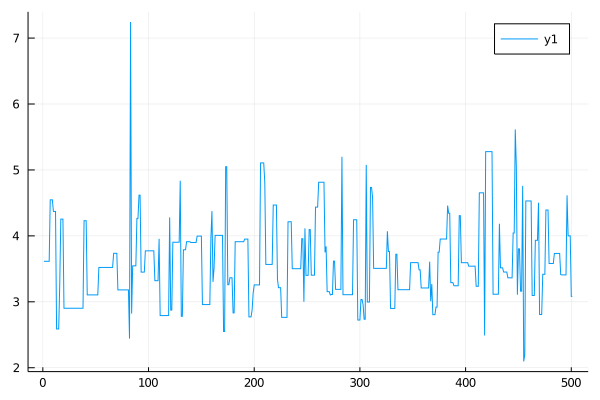

In [13]:
plot(chain[end-500:end,1])

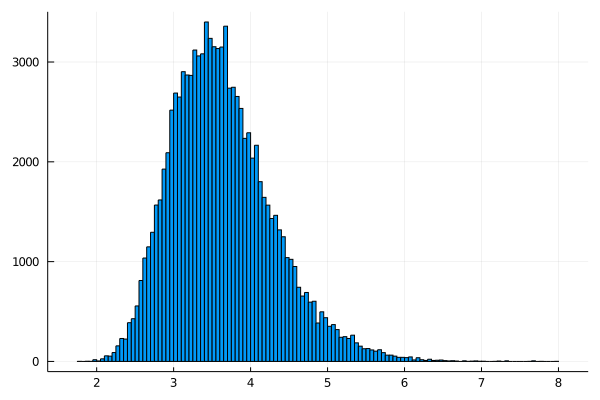

In [14]:
histogram(chain[:,1],legend=false)

Now let's graph:

In [87]:
function npdensity(z)
    #pyplot()
    n = size(z,2)
    p = zeros(n)
    for i = 1:n
        x = z[:,i]
        y = kde(x)
        q05 = quantile(x,0.05)
        Plots.plot(range(minimum(x), stop=q05, length=100),z->pdf(y,z), color=:orange, fill=(0,0.5,:orange), label="q05")
        q95 = quantile(x,0.95)
        Plots.plot!(range(q05, stop=q95, length=100),z->pdf(y,z), color=:green, fill=(0,0.5,:green),label="90% non-rejection region")
        Plots.plot!(range(q95, stop=maximum(x), length=100),z->pdf(y,z), color = :orange, fill=(0,0.5,:orange),label="q95")
        m = mean(x)
        Plots.plot!([m,m],[0,pdf(y,m)],color=:blue, label="mean")
        m = median(x)
        if i == 1
            p = Plots.plot!([m,m],[0,pdf(y,m)],color=:black, label="median")
        else
            p = [p, Plots.plot!([m,m],[0,pdf(y,m)],color=:black, label="median")]
        end
    end
    return p
end

npdensity (generic function with 1 method)

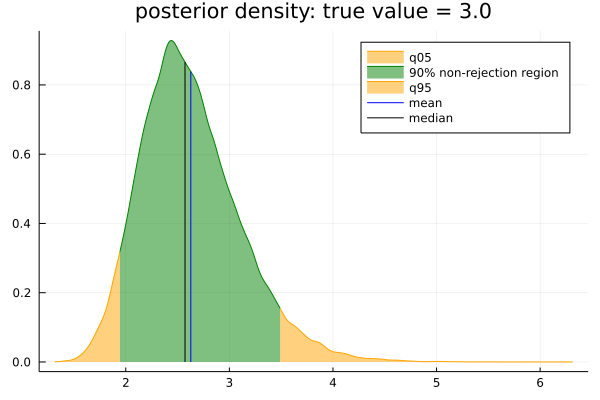

In [88]:
p = npdensity(chain[:,1]) # nonparametric plot of posterior density
plot!(p, title="posterior density: true value = 3.0") # add a title
display(p)

In [89]:
quantile(chain[:,1],.5)

2.571820929666873

In [90]:
mean(chain[:,1])

2.627835666992355

In [91]:
mean(chain,dims=1)

1×2 Array{Float64,2}:
 2.62784  0.39451

### Gibbs Samling


The algorithm:

0.$\quad$Assign starting values for $\theta$ with size $k$: $\theta^0$

1.$\quad$Set $j=j+1$

2.$\quad$Sample $(\theta_1^j \vert \theta_2^{j-1},\dots,\theta_k^{j-1})$

2.$\quad$Sample $(\theta_2^j \vert \theta_1^{j-1},\dots,\theta_k^{j-1})$

$\vdots$$\quad$$\vdots$

k+1.$\quad$Sample $(\theta_k^j \vert \theta_2^{j-1},\dots,\theta_{k-1}^{j-1})$

k+2.$\quad$Return to step 1.

Gibbs sampling is a special case of Metropolis-Hastings algorithm where the acceptance rate is equal to 1.

In other words, Gibbs sampling involves ordering the parameters and sampling
from the conditional distribution for each parameter given the current value of
all the other parameters and repeatedly cycling through this updating process.

For Gibbs sampling, the full conditional density for a parameter needs only
to be known up to a normalizing constant. This implies that we can use the joint density with the other parameters
set at their current values. This fact makes Gibbs sampling relatively simple
for most problems in which the joint density reduces to known forms for each
parameter once all other parameters are treated as fixed.

#### Example

Let's construct a **Gibbs sampler** for the bivariate distribution:
$$f(x,y)=kx^2e^{-xy^2-y^2+2y-4x}$$
where $x>0,y\in \mathcal{R}$
with unknown normalizing constant $k>0$ with unknown normalizing constant $k>0$.

You can think of $(x,y)$ as previously noted $\theta$.

The statistical motivation is not important for this post, but this is the kind of distribution which arises naturally in Bayesian inference for the mean and variance of a normal random sample. Gibbs sampling is a simple MCMC scheme which samples in turn from the full-conditional distributions.

In this case, then, are:

$$x\vert y \sim Gamma(3,y^2+4)$$
$$y\vert x \sim N\Big(\frac{1}{1+x},\frac{1}{\sqrt{2(1+x)}}\Big)$$

Given the full conditionals, alternately sample from them to construct a Gibbs sampler for the target distribution. We will run a Gibbs sampler with a thin of 1000 and obtain a final sample of 50000.

In [17]:
function Gibbs(reps::Int, burnin::Int)
    chain = fill(NaN, (reps,2))
    x   = 0.
    y   = 0.
    for i = 1:reps
        for j = 1:burnin
            x = rand(Gamma(3,(y*y + 4)))
            y = rand(Normal(1/(x+1),1/sqrt(2*(x + 1))))
        end
        chain[i,:] = [x,y]
    end
    return chain
end

Gibbs (generic function with 1 method)

In [18]:
chain = Gibbs(100000,1000)

100000×2 Array{Float64,2}:
  4.67647  -0.182837
  5.76694   0.225648
  5.71951   0.709085
  1.54357   0.847222
 12.915     0.168739
 10.2231    0.475535
 10.3196   -0.148784
  8.05318  -0.139629
  7.86046   0.537612
  7.25506   0.506774
  5.22541  -0.102717
  7.58817  -0.237087
  9.44253   0.185475
  ⋮        
  3.63053  -0.0363721
  6.59441  -0.0988208
 10.7533   -0.0555952
 30.5729   -0.00567513
  5.0229    0.137309
  2.70492   1.06705
 23.0421   -0.286004
  7.18185  -0.128605
  7.10599   0.048754
  1.33589   0.223614
 13.0347    0.266302
 13.802    -0.147551

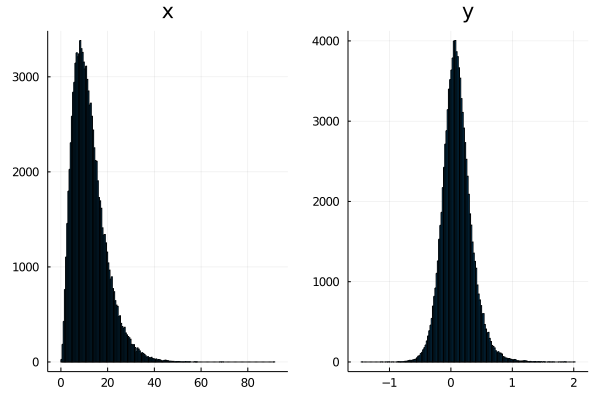

In [19]:
plot(chain,layout=2,seriestype=[:histogram],legend=false,title=["x" "y"])

In [21]:
mean(chain,dims=1)

1×2 Array{Float64,2}:
 12.2124  0.101961


## Convergence

Assume that we have a Markov chain $X_t$ generator with a help of Metropolis-Hastings algorithm (Gibb's sampling is a special case of it). The starting point is $X_0$. We are interested in convergence of the chain to its invariant distribution $\pi$. In other words, we expect: $P[X_t\in A \vert X_0]$ to converge to $\pi$ as $t\rightarrow\infty$.

If all values are visited with strictly positive probability and no partition that has strictly 1 probability, then:
$$\vert P[X_t\in A \vert X_0=x] -\pi(A) \vert \quad as t \rightarrow \infty $$


To detect convergence in practice one may do the following:
- check whether some characteristics of the chain distribution (such as mean, variance, median, quartiles)
are stabilize with time for a single long run;
- compare a ratios of a current estimate of a target density and a target density itself (known up to a
constant) for a single long run of a chain;
- compare some characteristics of the chain distribution across several independent runs of a chain.



General practical recommendations:
- There is no unique way to implement MCMC. In majority of cases you have many choices, try several
of them. It relates to choosing between different variants of M-H and Gibbs sampling as well as to
picking up sampling density q. For better results q should be appropriately centered and have tails
dominating π.
- I’ve seen a recommendation to tune your M-H algorithm to roughly 30% acceptance rate. I still don’t
know where the number comes from... The general wisdom is: if your acceptance rate is too low, then
you are producing very dependent draws; if your acceptance rate is too high, it may be the sign that
you are visiting only the high probability area and not moving too far from it.
- You should be very careful with choosing “non-informative” priors, since many of them tend to be
improper and may produce improper posteriors (ooo-u-ps!)